# Nipype Concepts: Workflows

![](http://nipy.sourceforge.net/nipype/_static/nipype-banner-bg.png)

The goal of this notebook is to introduce and illustrate the basic concepts underlying Workflows. Although it would be possible to write analysis scripts using just Nipype Interfaces, and this may provide some advantages over directly making command-line calls, the main benefits of Nipype will come by creating workflows.

First we'll use our helper function from before.

In [8]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nipype.interfaces import fsl


In [33]:
def plot_slice(fname, z_idx=5):

    # Load the image and collect the data
    # and orientation information
    img = nib.load(fname)
    data = img.get_data()
    aff = img.get_affine()

    # Find the center of the brain matrix
    ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

    # Plot the data
    vmin, vmax = (0, 1) if data.dtype == np.int16 else (30, 150)
    plt.imshow(np.rot90(data[:, :, int(ctr[2]) + int(z_idx)]),
           cmap="gray", vmin=vmin, vmax=vmax)
    plt.gca().set_axis_off()

To motivate the need for and principles behind workflows, let's start with a simple bit of preprocessing. We'd like to perform the following steps of processing. 

- Skullstrip an image to obtain a mask
- Smooth the original image
- Mask the smoothed image

Let's first see what this would look like with a shell script, using the Bash cell magic function. This is how FSL scripts are usually written.

In [26]:
%%bash
bet data/T1 data/T1_brain -m
fslmaths data/T1 -s 2 data/T1_smooth
fslmaths data/T1_smooth -mas data/T1_brain_mask data/T1_smooth_mask

This is simple and straightforward. We can see that this does exactly what we wanted by plotting the three steps of processing.

/Users/mdclark/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


[[[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 ..., 
 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]]
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.

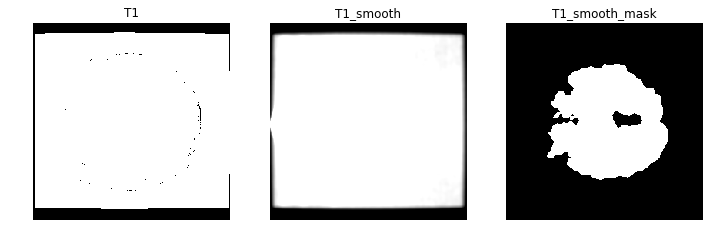

In [31]:
f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["T1", "T1_smooth", "T1_smooth_mask"]):
    f.add_subplot(1, 3, i + 1)
    plot_slice("data/%s.nii.gz" % img)
    plt.title(img)

The resulting images are exactly what we would expect given the script. Before moving on, let's clean these intermediate files

In [21]:
!make clean

make: *** No rule to make target `clean'.  Stop.


Now let's see what this would look like if we used Nipype, but only the Interfaces functionality. It's simple enough to write a basic procedural script, this time in Python, to do basically the same thing.

/Users/mdclark/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


[[[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 ..., 
 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]]
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 

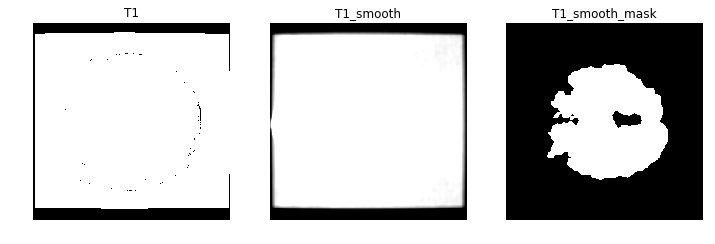

In [32]:
from nipype.interfaces import fsl

skullstrip = fsl.BET(in_file="data/T1.nii.gz", mask=True,
                     out_file="data/T1_brain.nii.gz")
res = skullstrip.run()

smooth = fsl.IsotropicSmooth(in_file="data/T1.nii.gz", fwhm=4,
                             out_file="data/T1_smooth.nii.gz")
smooth.run()

mask = fsl.ApplyMask(in_file="data/T1_smooth.nii.gz",
                     mask_file="data/T1_brain_mask.nii.gz",
                     out_file="data/T1_smooth_mask.nii.gz")
mask.run()

f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["T1", "T1_smooth", "T1_smooth_mask"]):
    f.add_subplot(1, 3, i + 1)
    plot_slice("data/%s.nii.gz" % img)
    plt.title(img)

This is more verbose, although it does have its advantages. There's the automated input validation we saw previously, some of the options are named more meaningfully, and you don't need to remember, for example, that fslmaths' smoothing kernel is set in sigma instead of FWHM -- Nipype does that conversion behind the scenes.

In this little script, we want the output of the BET command to be an input to the ApplyMask command. We accomplished this by manually ensuring that the two parameters are provided with the same filename. Let's use a little bit more of the Nipype Interfaces machinery to automate that processes somewhat.

In [23]:
!make clean

make: *** No rule to make target `clean'.  Stop.


/Users/mdclark/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


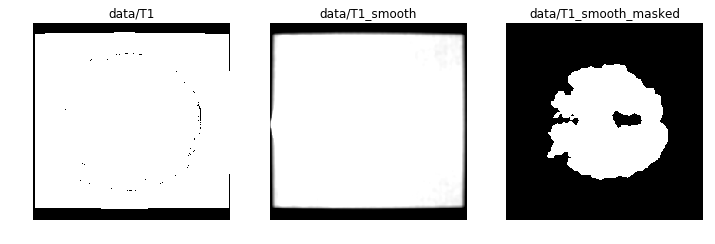

In [34]:
skullstrip = fsl.BET(in_file="data/T1.nii.gz", mask=True)
bet_result = skullstrip.run()

smooth = fsl.IsotropicSmooth(in_file="data/T1.nii.gz", fwhm=4)
smooth_result = smooth.run()

mask = fsl.ApplyMask(in_file=smooth_result.outputs.out_file,
                     mask_file=bet_result.outputs.mask_file)
mask.run()

f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["data/T1", "data/T1_smooth", "data/T1_smooth_masked"]):
    f.add_subplot(1, 3, i + 1)
    plot_slice("%s.nii.gz" % img)
    plt.title(img)

Here we didn't need to name the intermediate files; Nipype did that behind the scenes, and then we passed the result object (which knows those names) onto the next step in the processing stream. This is somewhat more concsise than the first Nipype version, but it's still a procedural script, and the dependency relationship between the stages of processing is not particularly obvious. To address these issues, and to provide solutions to problems we might not know we have yet, Nipype offers **Workflows.**

In [35]:
from nipype import Node, Workflow

What we've implicitly done above is to encode our processing stream as a directed acyclic graphs: each stage of processing is a node in this graph, and some nodes are unidirectionally dependent on others. In this case there is one input file and several output files, but there are no cycles -- there's a clear line of directionality to the processing. What the Node and Workflow classes do is make these relationships more explicit.

The basic architecture is that the Node provides a light wrapper around an Interface. It exposes the inputs and outputs of the Interface as its own, but it add some additional functionality that allows you to connect Nodes into a Workflow. Let's rewrite the above script with these tools.

In [36]:
# For reasons that will later become clear, it's important to
# pass filenames to Nodes as absolute paths
from os.path import abspath
in_file = abspath("data/T1.nii.gz")

skullstrip = Node(fsl.BET(in_file=in_file, mask=True), name="skullstrip")

smooth = Node(fsl.IsotropicSmooth(in_file=in_file, fwhm=4), name="smooth")

mask = Node(fsl.ApplyMask(), name="mask")

The first argument to Node is the iterface object that it will wrap, and then each Node needs a unique name. This doesn't need to bear any particular relationship to the variable name you assign the Node object to, but it's probably good form to keep them the same.

This looks mostly similar to what we did above, but we've left out the two crucial inputs to the ApppleMask step. We'll set those up by defining a Workflow object and then making *connections* among the Nodes.

In [37]:
wf = Workflow(name="smoothflow")  # Workflows need names too

The Workflow object has a method called ``connect`` that is going to do most of the work here. Let's look at its docstring.

In [38]:
print(wf.connect.__doc__)

Connect nodes in the pipeline.

        This routine also checks if inputs and outputs are actually provided by
        the nodes that are being connected.

        Creates edges in the directed graph using the nodes and edges specified
        in the `connection_list`.  Uses the NetworkX method
        DiGraph.add_edges_from.

        Parameters
        ----------

        args : list or a set of four positional arguments

            Four positional arguments of the form::

              connect(source, sourceoutput, dest, destinput)

            source : nodewrapper node
            sourceoutput : string (must be in source.outputs)
            dest : nodewrapper node
            destinput : string (must be in dest.inputs)

            A list of 3-tuples of the following form::

             [(source, target,
                 [('sourceoutput/attribute', 'targetinput'),
                 ...]),
             ...]

            Or::

             [(source, target, [(('sourceoutput1', func

We see that there are two ways to call `connect`. You can either make one connection at a time, or you can pass a list of several connections. In either case, you're providing it with four pieces of information to define the connection:

- The source node object
- The name of the output field from the source node
- The destination node object
- The name of the input field from the desination node

We'll illustrate each method in the following cell:

In [39]:
# First the "simple", but more restricted method
wf.connect(skullstrip, "mask_file", mask, "mask_file")

# Now the more complicated method. Note this way you can define several connections at once,
# and you can even define several connnections between two nodes in one smalller step
wf.connect([(smooth, mask, [("out_file", "in_file")])])

Now the workflow is complete. Above, we mentioned that the workflow can be thought of as a directed acyclic graph. In fact, that's literally how it's represented behind the scenes, and we can use that to explore the workflow visually:

170915-17:06:56,89 workflow INFO:
	 Converting dotfile: /Users/mdclark/Desktop/NIMS_to_BIDS/workflow_graph.dot to png format


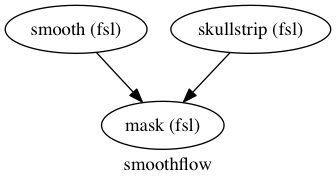

In [40]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="workflow_graph.dot.png")

This representation makes the dependency structure of the workflow obvious. (By the way, the names of the nodes in this graph are the names we gave our Node objects above, so pick something meaningful for those!)

At this point, all we've done is define the workflow. We haven't executed any code yet. Much like Interface objects, the Workflow object has a ``run`` method that we can call so that it executes. Let's do that and then examine the results.

In [41]:
!make clean

make: *** No rule to make target `clean'.  Stop.


In [42]:
wf.run()

170915-17:06:56,422 workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging']
170915-17:06:56,476 workflow INFO:
	 Running serially.
170915-17:06:56,477 workflow INFO:
	 Executing node smooth in dir: /var/folders/h8/65ng43ys2kq15bk1j4dm1n5r0000gp/T/tmpuah53b47/smoothflow/smooth
170915-17:06:56,482 workflow INFO:
	 Running: fslmaths /Users/mdclark/Desktop/NIMS_to_BIDS/data/T1.nii.gz -s 1.69864 /private/var/folders/h8/65ng43ys2kq15bk1j4dm1n5r0000gp/T/tmpuah53b47/smoothflow/smooth/T1_smooth.nii.gz
170915-17:07:04,234 workflow INFO:
	 Executing node skullstrip in dir: /var/folders/h8/65ng43ys2kq15bk1j4dm1n5r0000gp/T/tmp7moy6yw3/smoothflow/skullstrip
170915-17:07:04,240 workflow INFO:
	 Running: bet /Users/mdclark/Desktop/NIMS_to_BIDS/data/T1.nii.gz /private/var/folders/h8/65ng43ys2kq15bk1j4dm1n5r0000gp/T/tmp7moy6yw3/smoothflow/skullstrip/T1_brain.nii.gz -m
170915-17:07:08,394 workflow INFO:
	 Executing node mask in dir: /var/folders/h8/65ng43ys2kq15bk1j4dm1n5r0000gp/

We see that executing the workflow prints some verbose logging information to the screen. If we look closely, we see that things are actually being executed over in /tmp. This is fundamental to the concept of Nodes/Workflows (and is why we needed to use absolute paths above). Unlike interfaces, which by default spit out results to the local directry, the Workflow engine executes things off in its own directory hierarchy. By default this is a temporary directory, but you can set it manually.

In [ ]:
wf.base_dir = "working_dir"
wf.run()

Let's take a look at the resulting images to convince ourselves we've done the same thing as before

In [ ]:
f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["data/T1.nii.gz",
                         "working_dir/smoothflow/smooth/T1_smooth.nii.gz",
                         "working_dir/smoothflow/mask/T1_smooth_masked.nii.gz"]):
    f.add_subplot(1, 3, i + 1)
    plot_slice(img)

When you start writing full-fledged analysis workflows, things can get quite complicated. Some aspects of neuroimaging analysis can be thought of as a coherent step at a level more abstract than the execution of a single command line binary. For instance, in the standard FEAT script in FSL, several calls are made in the process of using `susan` to perform nonlinear smoothing on an image. In Nipype, you can write *nested workflows*, where a sub-workflow can take the place of a Node in a given script. That way, you can write smaller, more self-contained 

Let's use the prepackaged `susan` workflow that ships with Nipype to replace our gaussian filtering node and demonstrate how this works.

In [ ]:
from nipype.workflows.fmri.fsl import create_susan_smooth

Calling this function will return a pre-written `Workflow` object:

In [ ]:
susan = create_susan_smooth(separate_masks=False)

Let's display the graph to see what happens here.

In [ ]:
susan.write_graph("susan_workflow.dot")
Image(filename="susan_workflow.dot.png")

We see that the workflow has an `inputnode` and an `outputnode`. While not strictly necessary, this is standard practice for workflows (especially those that are intended to be used as nested workflows in the context of a longer analysis graph) and makes it more clear how to connect inputs and outputs from this workflow. Let's take a look at what those inputs and outputs are. Like Nodes, Workflows have `inputs` and `outputs` attributes that take a second subattribute corresponding to the specific node we want to make connections to.

In [ ]:
print("Inputs:")
print(susan.inputs.inputnode)
print("Outputs:")
print(susan.outputs.outputnode)

Note that `inputnode` and `outputnode` are just conventions, and the Workflow object exposes connections to all of its component nodes:

In [ ]:
print(susan.inputs.smooth)

Let's see how we would write a new workflow that uses this nested smoothing step. The susan workflow actually expects to receive and output a list of files (it's intended to be executed on each of several runs of fMRI data. We'll cover exactly how that works in later tutorials, but for the moment we need to add an additional `Function` node to deal with the fact that `susan` is outputting a list. We can use a simple `lambda` function; this is trivial.

In [ ]:
from nipype import Function
extract_func = lambda l: l[0]
list_extract = Node(Function(input_names=["l"], output_names=["out"],
                             function=extract_func), name="list_extract")

In [ ]:
wf2 = Workflow(name="susanflow", base_dir="working_dir")
skullstrip2 = Node(fsl.BET(in_file=in_file, mask=True), name="skullstrip")
mask2 = Node(fsl.ApplyMask(), name="mask")


wf2.connect([
    (skullstrip2, mask2, [("mask_file", "mask_file")]),
    (skullstrip2, susan, [("mask_file", "inputnode.mask_file")]),
    (susan, list_extract, [("outputnode.smoothed_files", "l")]),
    (list_extract, mask2, [("out", "in_file")])
    ])
susan.inputs.inputnode.in_files = abspath("data/T1.nii.gz")
susan.inputs.inputnode.fwhm = 5

First, let's see what this new processing graph looks like.

In [ ]:
wf2.write_graph("./full_susan_flow.dot")
Image(filename="full_susan_flow.dot.png")

We can see how there is a nested smoothing workflow in the place of our previous `smooth` node. This provides a very detailed view, but what if you just wanted to give a higher-level summary of the processing steps? After all, that is the purpose of encaupsulating smaller sterotyped streams in a nested workflow. That, fortunately, is an option when writing out the graph:

In [ ]:
wf2.write_graph("./full_susan_workflow_toplevel.dot", "orig")
Image(filename="full_susan_workflow_toplevel.dot.png")

That's much more managable. Now let's execute the workflow and examine the input and output:

In [ ]:
wf2.run()

In [ ]:
f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["data/T1.nii.gz",
                         "working_dir/susanflow/mask/T1_smooth_masked.nii.gz"]):
    f.add_subplot(1, 2, i + 1)
    plot_slice(img)

So far, we've seen that you can build up rather complex analysis workflows. But at the moment, it's not been made clear why this is worth the extra trouble from writing a simple procedural script. To demonstrate the first added benefit of the Nipype, let's return to our original workflow and run it again.

In [ ]:
wf.run()

That happened quickly! If you look at the log messages, you'll see `'Collecting precomputed outputs.'`  Workflows (actually this is handled by the Node code) are smart, and know if their inputs have changed from the last time they are run. If they have not, they don't recompute; they just turn around and pass out the resulting files from the previous run. This is done on a node-by-node basis, also. Here's what happened if we just tweak one thing:

In [ ]:
wf.inputs.smooth.fwhm = 1
wf.run()

We see that the smoothing stage was reexecuted, since its inputs had changed. This triggered a cascade such that any file depending on the ``smooth`` node (in this case, the ``mask`` node, also recomputed). However, the ``skullstrip`` node hasn't changed since the first time it ran, so it just coughed up its original files.

That's the first main benefit of using Workflows: efficient recomputing. 

So far, when we've called `wf.run()`, each step in the workflow has executed in serial using a single compute core. Perhaps the principle advantage of Nipype is how easily you can scale up a workflow to an extremely parallel cluster computing environment. The `run` method takes as argument a `Plugin` string or class. See [here](http://nipy.sourceforge.net/nipype/users/plugins.html) for detailed documentation. Basically, it works like this:

In [ ]:
wf.run("MultiProc")

You can also pass a dictionary of arguments that are relevant to the plugin; in the case of MultiProc, you can specify how large the worker pool should be:

In [ ]:
wf.run("MultiProc", dict(n_procs=2))

The `MultiProc` plugin uses the [multiprocessing](http://docs.python.org/library/multiprocessing.html) package in the standard library, and is the only parallel plugin that is garunteed to work right out of the box. However, Nipype comes provided with plugins to IPython's cluster architecture, SGE, PBS, and several other distributed engines. Because the workflow is represented as a directed graph, all Nodes with no parents or those whose parents have completed will run be executed simultaneously.

In this case, that just means that the `skullstrip` and `smooth` Nodes execute together, but when you scale up to Workflows with many subjects and many runs per subject (we will discuss how to accomplish this in following tutorials), each can run together, such that (in the case of unlimited computing resources), you could process 50 subjects with 10 runs of functional data in esentially the time it would take to process a single run.

To emphasize the contribution of Nipype here, you can write and test your workflow on one subject computing on your local CPU, where it is easier to debug. Then, with the change of a single function parameter, you can scale your processing up to a 1000+ node SGE cluster.

In [ ]:
!make clean